In [1]:
# Stock News Headline Sentiment Analysis through Vader & Roberta ( Pre Trained model )

# Step 1 : Importing Libraries..


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import time


In [2]:
#  Step 2 : Reading Data...

df = pd.read_csv('finviz-2-consolidated.csv')
print(df.shape)


(1011, 4)


In [3]:
# Table View
df.head()


,index,time,headline,symbol
0,0,Jul-29-24 03:48PM,HDFC Bank Limited 20-F Available Online,HDB
1,1,Jul-12-24 06:21PM,Should Investors Buy HDFC Bank (NYSE:HBD) for ...,HDB
2,2,05:55AM,Top 25 global banks add 5.4% market value duri...,HDB
3,3,Jul-09-24 09:14AM,Does HDFC Bank (HDB) Have a Low Incremental Ma...,HDB
4,4,Jul-03-24 06:51AM,MUFGs Talks for Stake in India Consumer Lender...,HDB


In [4]:
# Step 4 : VADER Seniment Scoring

# NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text
# Stop words are removed / each word is scored and combined to a total score.

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

example = df['headline'][22]
print(example)

sia.polarity_scores(example)


Top 25 Most Spoken Languages In The World 2024


{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'compound': 0.2023}

In [5]:
# Run the polarity score on the entire dataset
start = time.time()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['headline']
    myid = row['index']
    res[myid] = sia.polarity_scores(text)


vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'index'})
vaders = vaders.merge(df, how='left')

end = time.time()
print(f"Vader completed in {end-start}")


  0%|          | 0/1011 [00:00<?, ?it/s]

Vader completed in 0.2525761127471924


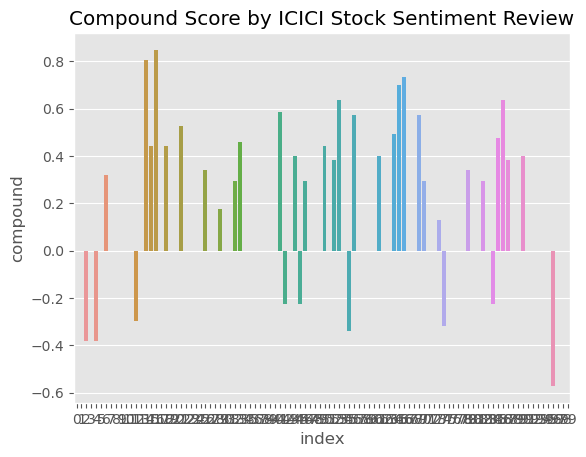

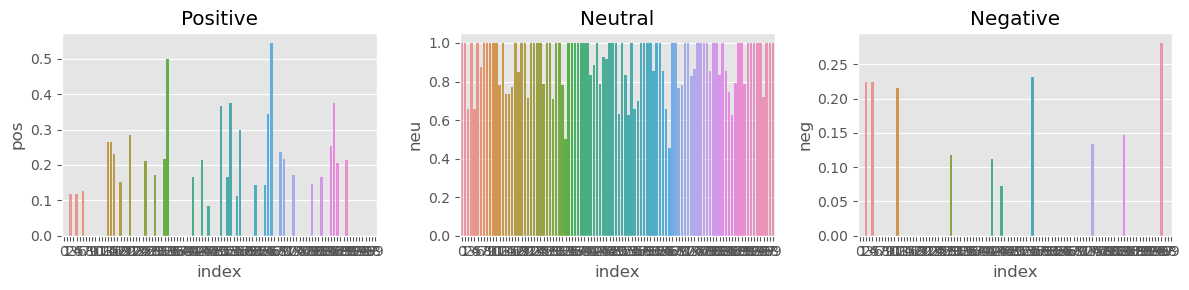

In [6]:
# Now we have sentiment score and metadata
vaders.head()

ax = sns.barplot(data=vaders, x='index', y='compound')
ax.set_title('Compound Score by ICICI Stock Sentiment Review')
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='index', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='index', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='index', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


In [7]:
#Step 3. Roberta Pretrained Model
# Use a model trained of a large corpus of data.
#Transformer model accounts for the words but also the context related to other words.


from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax


In [8]:


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


: 

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)


ICICI Bank (IBN) Q3 Earnings Improve on Higher NII, Costs Rise


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [ ]:

# Run for Roberta Model

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

start = time.time()
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['headline']
        myid = row['index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'index'})
results_df = results_df.merge(df, how='left')
end = time.time()
print(f"Roberta completed in {end-start}")

{'roberta_neg': 0.002960117, 'roberta_neu': 0.2441469, 'roberta_pos': 0.752893}


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Compare Scores between models
results_df.columns


Index(['Index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'time', 'headline'],
      dtype='object')

Roberta pre trained Model Scores


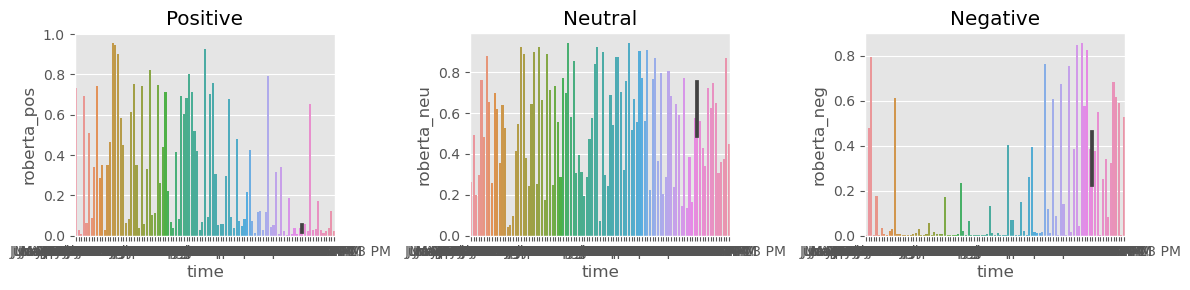

In [ ]:
print('Roberta pre trained Model Scores')

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='time', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='time', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='time', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

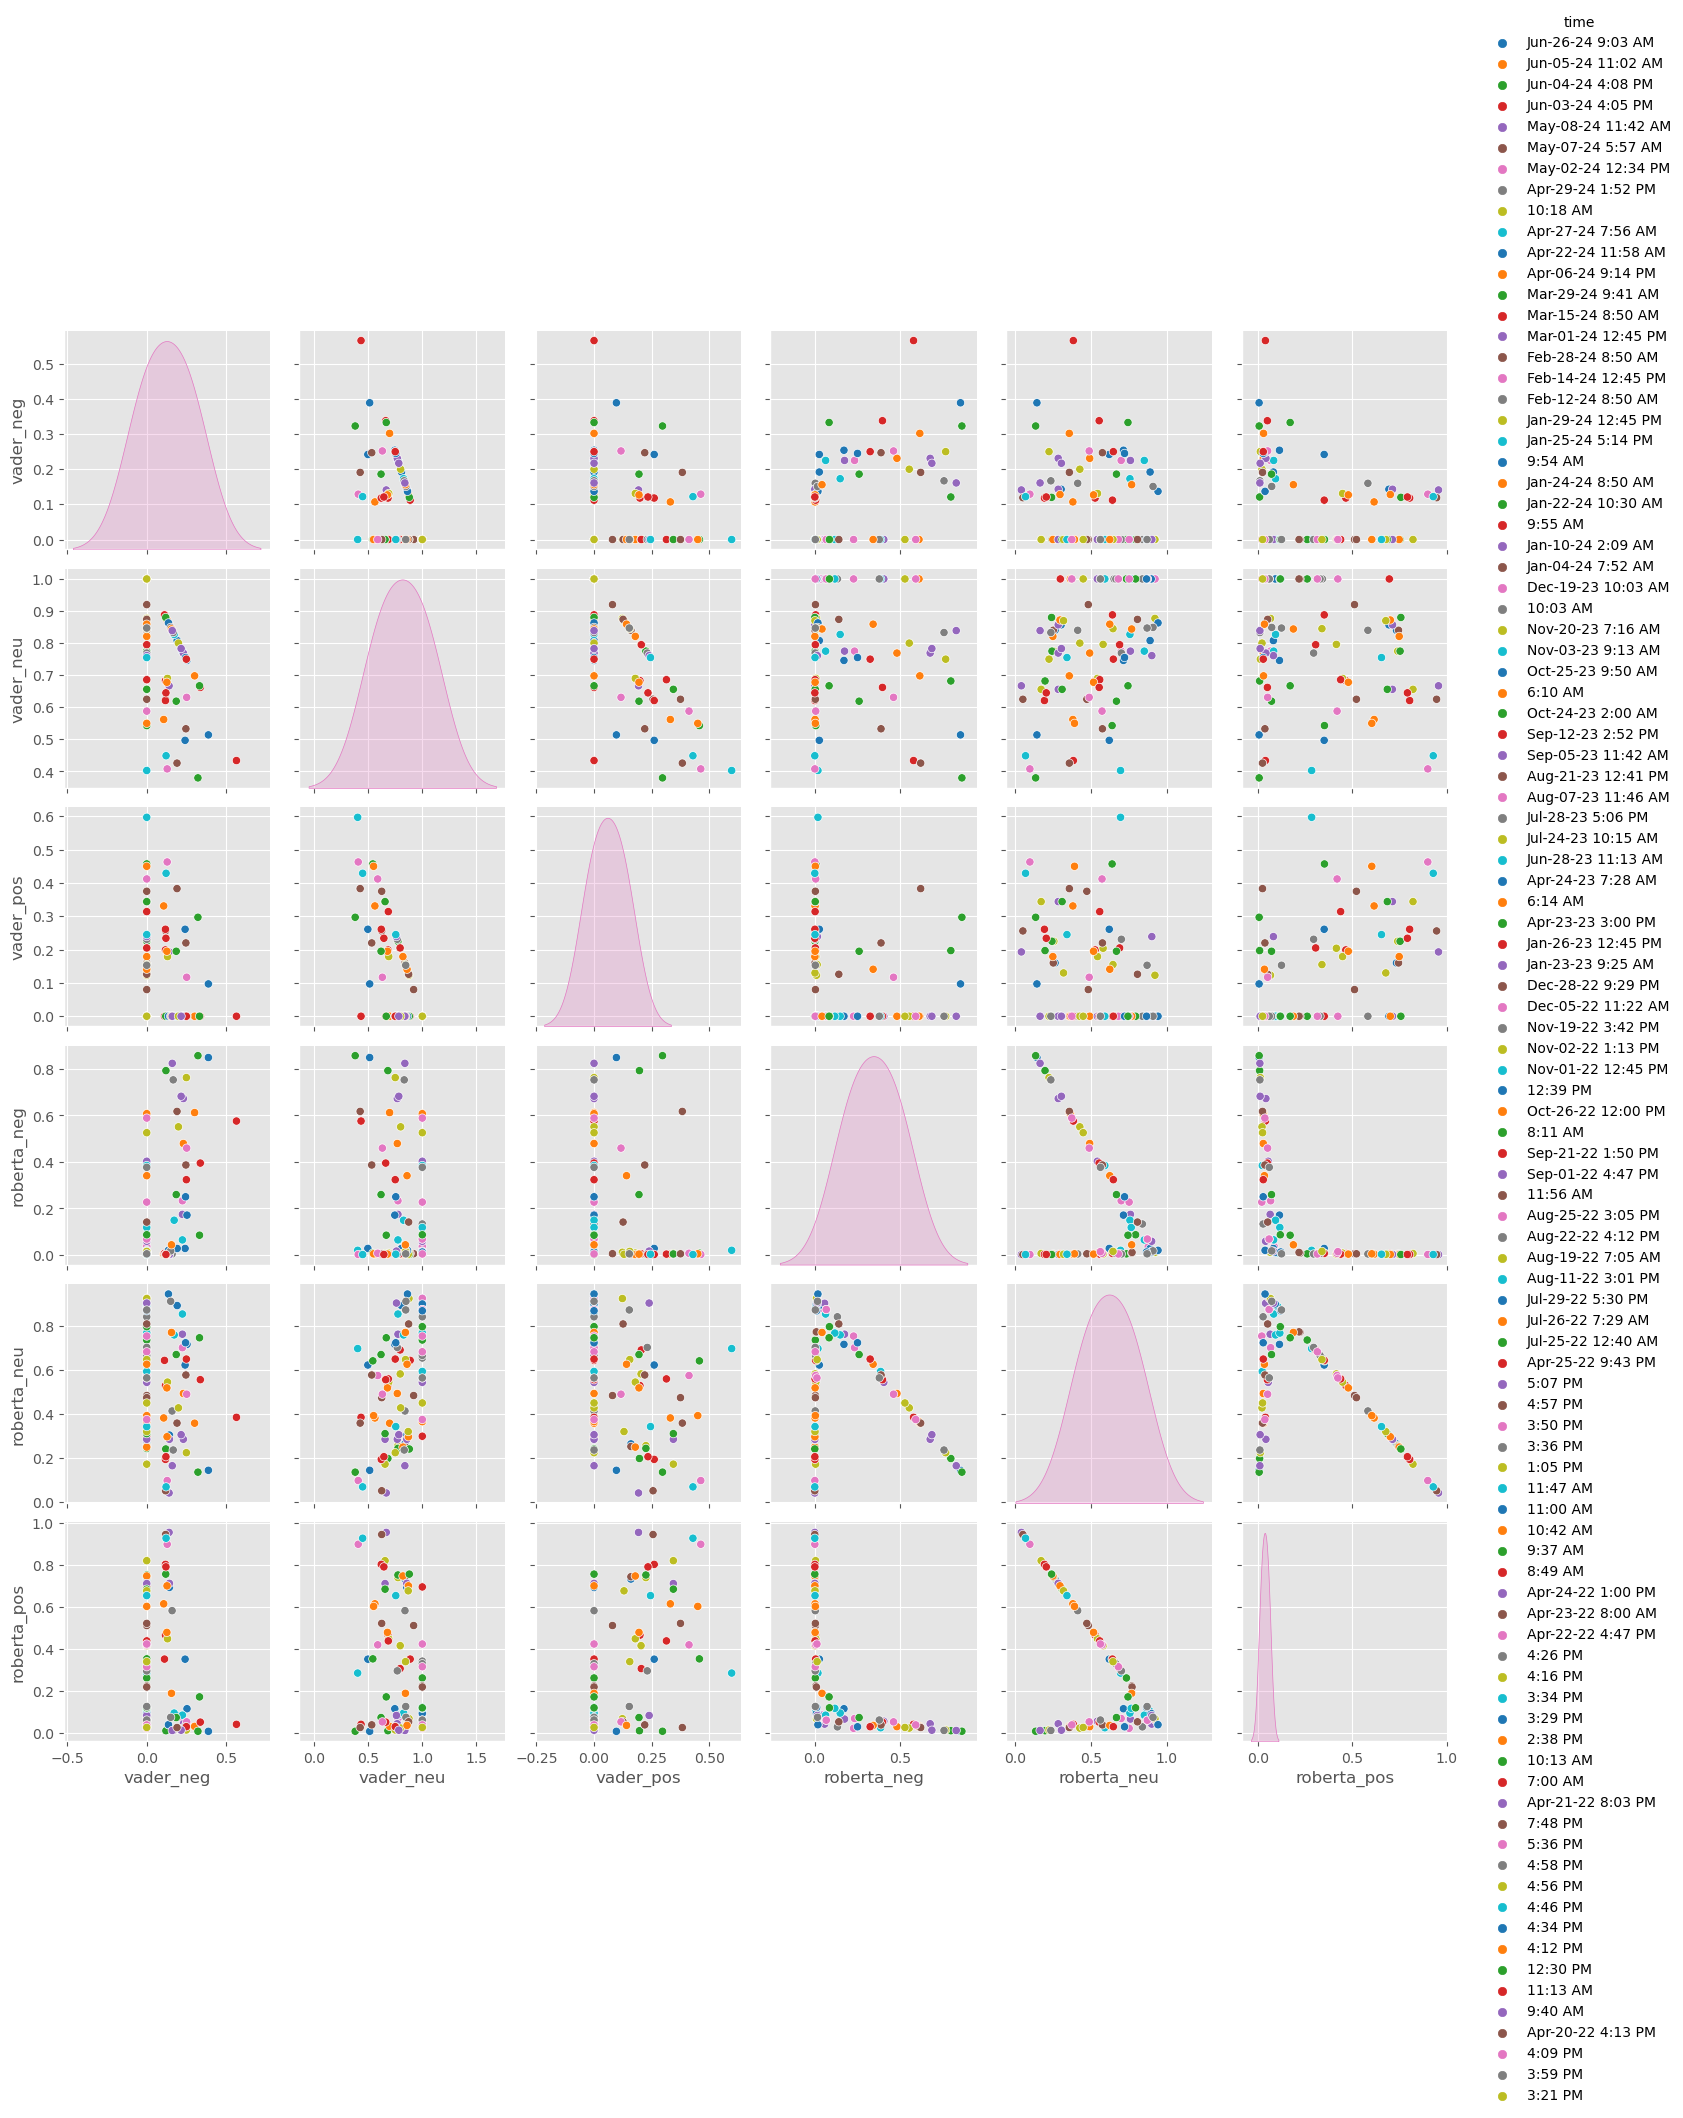

In [ ]:
# Combine scores and compare


sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='time',
            palette='tab10')
plt.show()


In [ ]:
# saving the dataframe
results_df.to_csv(r'finviz-2-consolidated_score.csv')

In [ ]:
results_df.head()

,Index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,time,headline
0,0,0.000,0.840,0.160,0.2263,0.002093,0.264436,0.733470,Jun-26-24 9:03 AM,ICICI Bank (IBN) is Now 18th Largest Bank Glob...
1,1,0.231,0.769,0.000,-0.4019,0.479284,0.492631,0.028085,Jun-05-24 11:02 AM,These India Stocks Pare Deep Losses In A Rolle...
2,2,0.121,0.682,0.197,0.2500,0.792937,0.198377,0.008686,Jun-04-24 4:08 PM,These India Stocks Sink As Modi Election Shock...
3,3,0.000,1.000,0.000,0.0000,0.005111,0.299150,0.695739,Jun-03-24 4:05 PM,India Stocks Rally On Modi Election Wave. Thes...
4,4,0.225,0.775,0.000,-0.4404,0.174478,0.761098,0.064424,May-08-24 11:42 AM,ICICI Bank (IBN) Rides on Loans & High Rates A...


In [ ]:
time_df = results_df

In [ ]:
import pandas as pd
from datetime import datetime


def fill_date(times):
    filled_times = []
    next_date = None

    for i in range(len(times) - 1, -1, -1):
        if '-' in times[i]:  # Full date-time string
            filled_times.append(times[i])
            next_date = datetime.strptime(times[i], '%b-%d-%y %I:%M %p')
        else:  # Only time string
            if next_date:
                filled_times.append(next_date.strftime('%b-%d-%y') + ' ' + times[i])
            else:
                filled_times.append(times[i])

    return filled_times[::-1]

# Store the new values in a new column called 'dateTime'
# time_df['dateTime'] = fill_date(time_df['time'])



In [ ]:
# time_df.to_csv("ICICI_datetime.csv")

In [ ]:
# time_df['roberta_sum'] = time_df['roberta_neg'] + time_df['roberta_neu'] + time_df['roberta_pos']
# time_df['roberta_neg_norm'] = time_df['roberta_neg']/time_df['roberta_sum']
# time_df['roberta_neu_norm'] = time_df['roberta_neu']/time_df['roberta_sum']
# time_df['roberta_pos_norm'] = time_df['roberta_pos']/time_df['roberta_sum']
# time_df['roberta_sum_norm'] = time_df['roberta_neg_norm'] + time_df['roberta_neu_norm'] + time_df['roberta_pos_norm']
